In [1]:
from griblib import ECMWF
from griblib.utils.geo import get_great_circle_path
from griblib.io.ascii import write_profile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.feature import BORDERS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


from scipy import ndimage
import pandas as pd
import glob
import pyproj

import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [4]:
# plotting parameters
temp_lim = {'min': 15.0, 'max': 30.0}
wind_lim = {'min': 15.0, 'max': 50.0}
w_lim = dict(min=-0.2, max=0.2)
msl_lim = {'min': 980.0, 'max': 1020.0 }
z_lim = {'min': 0.0, 'max': 65.0}

In [5]:
#fid_grib = 'data/beirut_era5_20200804_17.grib'
#model_type = 'ERA5'
fid_grib = 'data/beirut_hres_20200804_17.grib'
model_type = 'OPER'
fid_grib_z = 'data/beirut_hres_20200804_18.grib'

In [6]:
fid_ims_i = 'ims_infrasound.dat'
fid_ntl_i = 'stations.is_ntl'

In [7]:
cols = ['lat', 'lon', 'code']
df=pd.read_table(fid_ntl_i, sep='\s+', skiprows=0, names=cols)

In [8]:
ntl = df.loc[df['code'].isin(['IMAR', 'IPLOR', 'PSZI'])].reset_index(drop=True)
ntl

lat      lon   code
0  45.8512  26.6498  IPLOR
1  33.0195  35.3971   IMAR
2  47.9179  19.8935   PSZI

In [9]:
cols = ['lon', 'lat', 'code']
ims=pd.read_table(fid_ims_i, sep='\s+', skiprows=0, names=cols)

In [10]:
# parameters for great circle path
path_params = dict()
path_params['type'] = 'coordinates'
#'range-azimuth'
path_params['start'] = dict(lat=33.9621, lon=35.5635)
path_params['end'] = dict(lat=48.846135, lon=13.717930, name='I26DE')
#path_params['end'] = dict(lat=35.805200, lon=9.322900, name='I48TN')
#path_params['range'] = 1700.0e3
#path_params['azimuth'] = 26.0
dr = 10.0e3

lon = path_params['start']['lon']%360
lat = path_params['start']['lat']

(lons, lats, azi, dist) = get_great_circle_path(path_params, dr)

In [11]:
my_atmos = ECMWF()
my_atmos.cycle = '-{}'.format(model_type)

In [12]:
# ds = my_atmos.read_grib(fid_grib)

# request = [
#     {'level_type': 'hybrid'}
# ]
request = [
    {'level_type': 'hybrid', 'var_list': ['z', 'lnsp', 't', 'u', 'v', 'w', 'q']}
]

ds = my_atmos.read_grib(fid_grib, request, compat='override')

# Convert lnsp field to surface pressure (sp) and add to dataset
sp = my_atmos.convert_lnsp_to_sp(ds.lnsp)
ds = xr.merge([sp.to_dataset(), ds])
ds = ds.drop(['lnsp'])

********************************************************************************
Reading ECMWF cy-OPER GRIB file [ data/beirut_hres_20200804_17.grib ]

Reading GRIB PV coefficients
Reading z on hybrid level
 - **ERROR**: variable z not found. Skipping...
Reading lnsp on hybrid level
Reading t on hybrid level
Reading u on hybrid level
Reading v on hybrid level
Reading w on hybrid level
Reading q on hybrid level


### Add geopotential to dataset (in case of Forecast file)

In [13]:
dsz = my_atmos.read_grib(fid_grib_z, request = [{'level_type': 'hybrid', 'var_list': 'z'}])
ds = xr.merge([ds, dsz], compat='override')

********************************************************************************
Reading ECMWF cy-OPER GRIB file [ data/beirut_hres_20200804_18.grib ]

Reading GRIB PV coefficients
Reading z on hybrid level


In [14]:
# # add lon = 360 deg entry in dataset
# ds = my_atmos.wrap_around_360deg_dataset(ds)

In [15]:
# Compute altitude with respect to mean sea level
(z, pres) = my_atmos.compute_altitude_pressure(t=ds.t, q=ds.q, ps=ds.sp, 
                                               z0=ds.z)

# Also compute height above ground (z = 0 km)
(hgt, _) = my_atmos.compute_altitude_pressure(t=ds.t, q=ds.q, ps=ds.sp, 
                                              z0=ds.z*0.0)
hgt = hgt.rename('hgt')
hgt.attrs= {'long_name': 'height above ground',
            'units' : 'm',
            'standard_name': 'height_above_ground'}
    
dens = my_atmos.compute_density(pres, ds.t)

# compute mean sea level pressure
msl = my_atmos.compute_mean_sea_level_pressure(pres_surface=ds.sp,
                                               z_surface=z.sel(hybrid=len(ds.hybrid)),
                                               t_surface=ds.t.sel(hybrid=len(ds.hybrid)))

ds = ds.drop(['z'])
ds = xr.merge([z.to_dataset(), hgt.to_dataset(),
               pres.to_dataset(), msl.to_dataset(),
               dens.to_dataset(), ds])

## Plotting pressure model parameters

In [16]:
def plot_prefix(self, ds):
    t_fcst=(ds.valid_time).dt.strftime('%Y%m%d-%H').values

    title_str = '{model}{cycle} forecast {time} UT'.format(
        model=self.model, cycle=self.cycle, time=t_fcst)

    fid_prefix = '{model}{cycle}_{time}'.format(model=self.model, 
                                                cycle=self.cycle, 
                                                time=t_fcst)
    return (t_fcst, title_str, fid_prefix)

(t_fcst, title_str, fid_prefix) = plot_prefix(my_atmos, ds)

In [17]:
def plot_pressure(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)
    
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,6),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.01, hspace=0.15)

    ds.pres_msl.plot(cmap='RdBu_r',
                  ax=ax[0,0],
                  vmin=P_lim['min'], vmax=P_lim['max'],
                  robust=True,
                  transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ###################

    ds.pdep.sel(hybrid=20).plot(cmap='RdBu_r',
                  ax=ax[0,1],
                  vmin=-10, vmax=10,
                  robust=True,
    #               vmin=-1, vmax=1,
                  transform=ccrs.PlateCarree())
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    ###################
    ds.pres_lp.plot(cmap='RdBu_r',
                    ax=ax[1,0],
                    robust=True,
                    vmin=-3, vmax=3,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-4,4,1)
    ds.pres_lp.plot.contour(ax=ax[1,0],
                            colors='black',
                            levels=levels,
                            linewidths=.25, 
                            transform=ccrs.PlateCarree())
    ###################
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[1,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    transform=ccrs.PlateCarree())
    levels = np.arange(-2,2,1)
    # msl_filt.plot.contour(ax=ax[0],
    #                       colors='black',
    #                       levels=levels,
    #                       linewidths=.25, 
    #                       transform=ccrs.PlateCarree())

    for i in range(0,2):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())
            
    fig.suptitle(title_str)

    fid = '{}_map_pressure.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white')
    #fig.savefig('../'+fid, facecolor='white')

In [18]:
def plot_meteo(self, ds):
    (t_fcst, title_str, fid_prefix) = plot_prefix(self, ds)
    ground_level = len(ds.hybrid)

    fig, ax = plt.subplots(3, 2, sharex=True, sharey=True,  figsize=(12,10),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.1, hspace=0.1)


    ####### MEAN SEA LEVEL PRESSURE ##############
    ds.pres_msl.plot(cmap='RdBu_r',
                      ax=ax[0,0],
                      robust=True,
                      vmin=P_lim['min'], vmax=P_lim['max'],
                      extend='both',
                      transform=ccrs.PlateCarree())
    levels = np.arange(980,1030,2)
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.2,
                           linewidths=2.0, 
                           transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[0,0],
                           colors='black',
                           levels=levels,
                           alpha=0.9,
                           linewidths=0.25, 
                           transform=ccrs.PlateCarree())

    ####### WINDSPEED and DIRECTION ##############
#     ds.windgust_speed.plot(cmap='inferno_r',
#                            ax=ax[1,0],
#                            robust=True,
#                            vmin=wind_lim['min'], vmax=wind_lim['max'],
#                            extend='both',
#                            transform=ccrs.PlateCarree())
    ds.wind_speed.sel(hybrid=20).plot(cmap='inferno_r',
                           ax=ax[1,0],
                           robust=True,
                           vmin=wind_lim['min'], vmax=40.0,
                           extend='both',
                           transform=ccrs.PlateCarree())
    
    # reinterpolate for wind arrows
    _lon = np.arange(ds.longitude.min(), ds.longitude.max(), 0.5)
    _lat = np.arange(ds.latitude.min(), ds.latitude.max(), 0.5)
    ds.load()
    u_ = ds.ugst.interp(latitude=_lat, longitude=_lon)
    v_ = ds.vgst.interp(latitude=_lat, longitude=_lon)
    w_ = np.sqrt(u_**2+v_**2)
    u_ = u_.where(w_ > 0.95*wind_lim['min']) / w_
    v_ = v_.where(w_ > 0.95*wind_lim['min']) / w_

    ax[1,0].quiver(_lon, _lat, u_.values, v_.values,
                    scale=25,
                    edgecolor='w',
                    width=0.005,
                    linewidth=0.5,
                    transform=ccrs.PlateCarree())

    ####### PRESSURE DEPARTURE ########################
    # ds['pdep'].sel(hybrid=ground_level).plot(cmap='RdBu_r',
    #                                 ax=ax[0,1],
    #                                 robust=True,
    #                                 vmin=-10, vmax=10,
    #                                 transform=ccrs.PlateCarree())
    ds.pres_hp.plot(cmap='RdBu_r',
                    ax=ax[0,1],
                    robust=True,
                    vmin=-1, vmax=1,
                    extend='both',
                    transform=ccrs.PlateCarree())


    ####### TURBULENT PRESSURE ##############
    # turbulence = ds['tke'].sel(hybrid=ground_level)
    # turbulence.attrs={'long_name': 'Turbulent Kinetic Energy',
    #             'units' : 'm$^2$/s$^2$',
    #             'standard_name': 'TKE'}
    ds.pres_turb.plot(cmap='gist_stern_r',
                        ax=ax[1,1],
                        robust=True,
                        vmin=ptke_lim['min'],vmax=ptke_lim['max'],
                        extend='both',
                        transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[1,1],
                                colors='black',
                                levels=levels,
                                alpha=0.2,
                                linewidths=2.0, 
                                transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[1,1],
                                colors='black',
                                levels=levels,
                                alpha=0.9,
                                linewidths=0.25, 
                                transform=ccrs.PlateCarree())

    ####### PRECIPITATION AND ISOBARS ##############

    ds.rain.plot(cmap='gist_stern_r',
                    ax=ax[2,0],
                    robust=True,
                    norm=colors.LogNorm(vmin=rain_lim['min'],vmax=rain_lim['max']),
                    extend='both',
                    transform=ccrs.PlateCarree())

    ds.pres_msl.plot.contour(ax=ax[2,0],
                                colors='black',
                                levels=levels,
                                alpha=0.2,
                                linewidths=2.0, 
                                transform=ccrs.PlateCarree())
    ds.pres_msl.plot.contour(ax=ax[2,0],
                               colors='black',
                               levels=levels,
                               alpha=0.9,
                               linewidths=0.25, 
                               transform=ccrs.PlateCarree())


    ####### MIXED LAYER HEIGHT ##############

    ds.mld.plot(cmap='gist_stern_r',
                ax=ax[2,1],
                robust=True,
                vmin=mld_lim['min'], vmax=mld_lim['max'],
                extend='both',
                transform=ccrs.PlateCarree())

    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel('')
    ax[1,1].set_ylabel('')
    ax[0,0].set_xlabel('')

    for i in range(0,3):
        for j in range(0,2):
            ax[i,j].set_title('')
            ax[i,j].set_extent((ds.longitude.min(), ds.longitude.max(),
                                ds.latitude.min(), ds.latitude.max()))
            # add Borders and so
            ax[i,j].coastlines(linewidth=.8, edgecolor='gray')
            ax[i,j].add_feature(BORDERS, linewidth=.8, edgecolor='black')
            # add Dutch provinces
            ax[i,j].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                              edgecolor='darkgray', facecolor='gray', alpha=0.2)

            #Plot great-circle path
            ax[i,j].scatter(path_params['start']['lon']%360,
                            path_params['start']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].scatter(path_params['end']['lon']%360,
                            path_params['end']['lat'],
                            c='C0', edgecolors='white', marker='o',
                            transform=ccrs.PlateCarree())
            ax[i,j].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
                         path_effects=[pe.Stroke(linewidth=5, foreground='w', alpha=0.75), pe.Normal()])
            # Plot (random) sampling point
            ax[i,j].scatter(df.Longitude, df.Latitude,
                            c='white', edgecolor='black', transform=ccrs.PlateCarree())

    fig.suptitle(title_str)

    fid = '{}_map_meteo.png'.format(fid_prefix)
    fig.savefig(fid, facecolor='white')
    #fig.savefig('../'+fid, facecolor='white')

In [19]:
# plot_pressure(my_atmos, ds)

In [20]:
# plot_meteo(my_atmos, ds)

In [21]:
# path_params['start'] = dict(lat=50, lon=20)
# (lons, lats, azi, dist) = get_great_circle_path(path_params, dr)

my_atmos.compute_azimuth_grid(ds, source=path_params['start'])
(cT, wa, wc, ce) = my_atmos.infrasound_propagation_conditions(t=ds.t,
                                                              u=ds.u,
                                                              v=ds.v,
                                                              azimuth=ds.azimuth)

c0 = ce.sel(hybrid=len(ds.hybrid))
cr = my_atmos.effective_sound_speed_ratio(ce, c0)

ds = xr.merge([cT.to_dataset(),
               wa.to_dataset(),
               wc.to_dataset(),
               ce.to_dataset(),
               cr.to_dataset(),
               ds],
               compat='override')

In [22]:
def plot_infrasound_map(self, ds, layer):
    (t_fcst, model_str, fid_prefix) = plot_prefix(self, ds)
    
    dim = layer['selection']['level_type']
    lev1 = layer['selection']['lev1']
    lev2 = layer['selection']['lev2']
    a = { dim: lev1 }
    b = { dim: lev2 }
    slice_select = { dim: slice(lev1, lev2) }

    z2 = ds.z.sel(a).mean().data
    z1 = ds.z.sel(b).mean().data

    title_str = '{} - propagation conditions'.format(model_str)
    if z1 == z2:
        title_str += ' at {:.0f} km'.format(z1/1e3)
    else:
        title_str += ' between {:.0f} - {:.0f} km'.format(z1/1e3, z2/1e3)
    print(title_str)

    area_data = [ds.longitude.min(), ds.longitude.max(),
                 ds.latitude.min(), ds.latitude.max()]
    area_plot = [ds.longitude.min(), ds.longitude.max(),
                 ds.latitude.min(), ds.latitude.max()-1.5]

    fig, ax = plt.subplots(1, 3, figsize=(9,5),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.1,
                        right=0.9, wspace=0.1, hspace=0.15)

    # Plot adiabatic sound speed
    if layer['fid'] == 'surface':
        ct_min = 338
        ct_max = 351
    elif layer['fid'] == 'jetstream':
        ct_min = 300
        ct_max = 320
    else:
        ct_min = 320
        ct_max = 340
    xx = ds.cT.sel(slice_select).max(dim=dim)
    im = ax[0].imshow(xx, cmap='Spectral_r',
                      origin='upper', extent=area_data,
                      interpolation='bilinear',
                      vmin=ct_min, vmax=ct_max,
                      transform=ccrs.PlateCarree())

    cb_ax = fig.add_axes([0.10, 0.875, 0.225, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
    cbar.set_label(label='$c_{T}$ [m/s]', size=9)


    # Plot wind and wind direction
    if layer['fid'] == 'surface':
        wa_min = -20
        wa_max = 20
    elif layer['fid'] == 'jetstream':
        wa_min = -20
        wa_max = 20
    else:
        wa_min = -50
        wa_max = 50
    u = ds.u.sel(slice_select).max(dim=dim)
    v = ds.v.sel(slice_select).max(dim=dim)
    w = np.sqrt(u**2+v**2)
    # reinterpolate for wind arrows
    _lon = np.arange(ds.longitude.min(), ds.longitude.max(), 5.0)
    _lat = np.arange(ds.latitude.min(), ds.latitude.max(), 5.0)
    ds.load()
    u_ = u.interp(latitude=_lat, longitude=_lon)
    v_ = v.interp(latitude=_lat, longitude=_lon)
    w_ = np.sqrt(u_**2+v_**2)
    # u_ = u_.where(w_ > 0.95*wind_lim['min']) / w_
    # v_ = v_.where(w_ > 0.95*wind_lim['min']) / w_
    u_ = u_ / w_
    v_ = v_ / w_

    xx = ds.wa.sel(slice_select).max(dim=dim)
    im = ax[1].imshow(xx, cmap='RdBu_r',
                      origin='upper', extent=area_data,
                      interpolation='bilinear', 
                      transform=ccrs.PlateCarree(), vmin=wa_min, vmax=wa_max)
    ax[1].quiver(_lon, _lat, u_.values, v_.values,
              scale=20,
              edgecolor='w',
              width=0.008,
              linewidth=0.5,
              transform=ccrs.PlateCarree())

    cb_ax = fig.add_axes([0.41, 0.875, 0.225, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
    cbar.set_label(label='$w_{a}$ [m/s]', size=9)

    # Plot effective sound speed ratio
    if layer['fid'] == 'surface':
        cr_min = 0.999
        cr_max = 1.05
    elif layer['fid'] == 'jetstream':
        cr_min = 0.99
        cr_max = 1.05
    else:
        cr_min = 0.99
        cr_max = 1.15
    xx = ds.cr.sel(slice_select).max(dim=dim)
    xx = xx.where(xx > 0.999)

    im = ax[2].imshow(xx, cmap='inferno_r',
                      origin='upper', extent=area_data, interpolation='bilinear', 
                      transform=ccrs.PlateCarree(), vmin=cr_min, vmax=cr_max)
    cb_ax = fig.add_axes([0.73, 0.875, 0.225, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
    cbar.set_label(label='$c_{e}$ ratio [-]', size=9)

    ax[2].quiver(_lon, _lat, u_.values, v_.values,
              scale=20,
              edgecolor='w',
              width=0.008,
              linewidth=0.5,
              transform=ccrs.PlateCarree())


    # General plotting aspect
    lon_labels = np.arange(area_plot[0], area_plot[1], 5.0)
    lat_labels = np.arange(area_plot[2], area_plot[3], 5.0)

    for i in range (0,3):
        ax[i].set_extent(area_plot)
        ax[i].set_aspect(aspect=1.3)

        #add Borders and so
        ax[i].coastlines(linewidth=.5, color='black')
        ax[i].add_feature(BORDERS, linewidth=0.5, color='black')

        #gl = ax[i].gridlines(linestyle=":", dms=True)

        #ax[i].set_yticks(lat_labels)
        ax[i].set_xticks(lon_labels)
        ax[i].set_xlabel('Longitude (deg)')
        ax[i].set_ylabel('')

        ax[i].scatter(ims['lon']%360,
                      ims['lat'],
                      c='C0', edgecolors='white', linewidth=0.75, marker='^', s=80,
                      transform=ccrs.PlateCarree())
        ax[i].scatter(ntl['lon']%360,
                      ntl['lat'],
                      c='red', edgecolors='white', linewidth=0.75, marker='^', s=80,
                      transform=ccrs.PlateCarree())
        ax[i].scatter(path_params['start']['lon']%360,
                      path_params['start']['lat'],
                      c='white', edgecolor='black', 
                      marker='*', s=192, transform=ccrs.PlateCarree())        
        
    # # gl.xlocator = mticker.FixedLocator(lon_labels)
    # # gl.ylocator = mticker.FixedLocator(lat_labels)
    # # gl.top_labels = gl.right_labels = False

    ax[2].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
               path_effects=[pe.Stroke(linewidth=5.0, foreground='w', alpha=0.75), pe.Normal()])
    ax[2].scatter(path_params['end']['lon']%360,
                  path_params['end']['lat'],
                  c='C0', edgecolors='white', linewidth=2.0, marker='o', s=100,
                  transform=ccrs.PlateCarree())

    ax[0].set_yticks(lat_labels)
    ax[0].set_ylabel('Latitude (deg)')

    fig.suptitle(title_str)
    fig.tight_layout()

    fid_gcp = '{}_{}_map.png'.format(fid_prefix, layer['fid'])
    fig.savefig(fid_gcp, facecolor='white', bbox_inches = 'tight')

    plt.show()

ECMWF-OPER forecast 20200804-17 UT - propagation conditions between 0 - 6 km


<ipython-input-22-0d3f906e064a>:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/Users/assink/opt/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


ECMWF-OPER forecast 20200804-17 UT - propagation conditions between 9 - 15 km


<ipython-input-22-0d3f906e064a>:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/Users/assink/opt/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


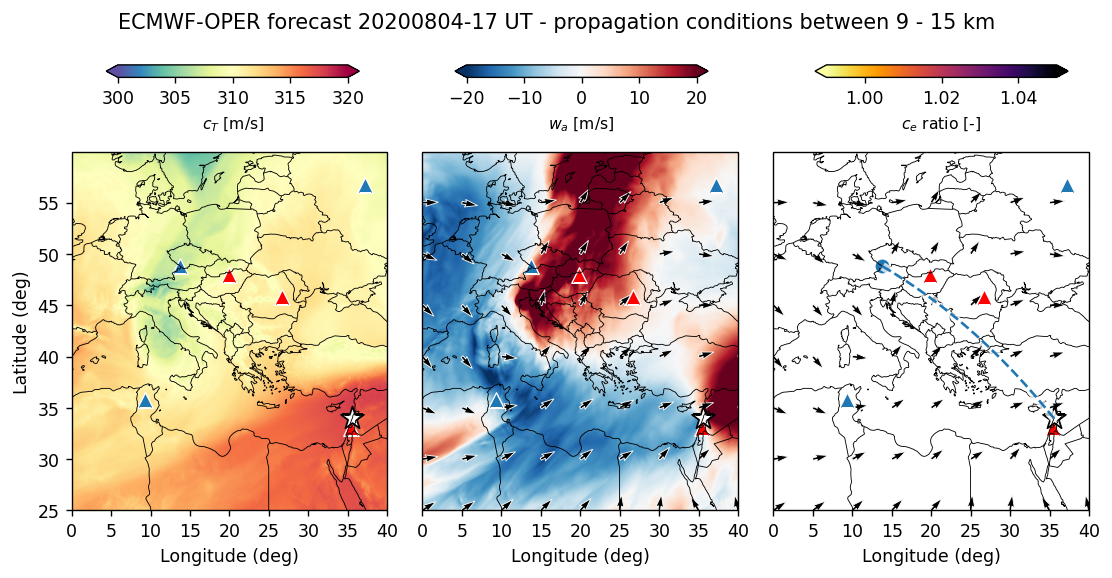

ECMWF-OPER forecast 20200804-17 UT - propagation conditions between 41 - 60 km


<ipython-input-22-0d3f906e064a>:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/Users/assink/opt/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


In [23]:
layers = dict()
layers['surface'] = dict(fid='surface', description='Near surface (0-6 km)',
                         selection=dict(level_type='hybrid', lev1=94, lev2=136))
layers['jetstream'] = dict(fid='jetstream', description='Jetstream (9-15 km)',
                           selection=dict(level_type='hybrid', lev1=65, lev2=85))
layers['strato'] = dict(fid='strato', description='Stratosphere (40-60 km)',
                        selection=dict(level_type='hybrid', lev1=8, lev2=20))

for item in layers.keys():
    plot_infrasound_map(my_atmos, ds, layers[item])

In [24]:
def plot_infrasound_map_arome(self, ds, layer):
    (t_fcst, model_str, fid_prefix) = plot_prefix(self, ds)
    
    dim = layer['selection']['level_type']
    lev1 = layer['selection']['lev1']
    lev2 = layer['selection']['lev2']
    a = { dim: lev1 }
    b = { dim: lev2 }
    slice_select = { dim: slice(lev1, lev2) }

    z2 = ds.z.sel(a).mean().data
    z1 = ds.z.sel(b).mean().data

    title_str = '{} - propagation conditions'.format(model_str)
    if z1 == z2:
        title_str += ' at {:.0f} km'.format(z1/1e3)
    else:
        title_str += ' between {:.0f} - {:.0f} km'.format(z1/1e3, z2/1e3)
    print(title_str)

    area_data = [ds.longitude.min(), ds.longitude.max(),
                 ds.latitude.min(), ds.latitude.max()]
    area_plot = [6.00, 22.102, 42.981, 51.819]

    fig, ax = plt.subplots(1, 3, figsize=(9,4),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.1,
                        right=0.9, wspace=0.15, hspace=0.15)

    # Plot adiabatic sound speed
    xx = ds.cT.sel(slice_select).max(dim=dim)
    im = ax[0].imshow(xx, cmap='Spectral_r',
                      origin='upper', extent=area_data,
                      interpolation='bilinear',
                      vmin=338, vmax=351,
                      transform=ccrs.PlateCarree())

    cb_ax = fig.add_axes([0.10, 0.875, 0.225, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
    cbar.set_label(label='$c_{T}$ [m/s]', size=9)


    # Plot wind and wind direction
    u = ds.u.sel(slice_select).max(dim=dim)
    v = ds.v.sel(slice_select).max(dim=dim)
    w = np.sqrt(u**2+v**2)
    # reinterpolate for wind arrows
    _lon = np.arange(ds.longitude.min(), ds.longitude.max(), 2.0)
    _lat = np.arange(ds.latitude.min(), ds.latitude.max(), 2.0)
    ds.load()
    u_ = u.interp(latitude=_lat, longitude=_lon)
    v_ = v.interp(latitude=_lat, longitude=_lon)
    w_ = np.sqrt(u_**2+v_**2)
    # u_ = u_.where(w_ > 0.95*wind_lim['min']) / w_
    # v_ = v_.where(w_ > 0.95*wind_lim['min']) / w_
    u_ = u_ / w_
    v_ = v_ / w_

    xx = ds.wa.sel(slice_select).max(dim=dim)
    im = ax[1].imshow(xx, cmap='RdBu_r',
                      origin='upper', extent=area_data,
                      interpolation='bilinear', 
                      transform=ccrs.PlateCarree(), vmin=-20, vmax=20)
    ax[1].quiver(_lon, _lat, u_.values, v_.values,
              scale=20,
              edgecolor='w',
              width=0.008,
              linewidth=0.5,
              transform=ccrs.PlateCarree())

    cb_ax = fig.add_axes([0.38, 0.875, 0.225, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
    cbar.set_label(label='$w_{a}$ [m/s]', size=9)

    # Plot effective sound speed ratio
    xx = ds.cr.sel(slice_select).max(dim=dim)
    xx = xx.where(xx > 0.999)

    im = ax[2].imshow(xx, cmap='inferno_r',
                      origin='upper', extent=area_data, interpolation='bilinear', 
                      transform=ccrs.PlateCarree(), vmin=0.999, vmax=1.05)
    cb_ax = fig.add_axes([0.66, 0.875, 0.225, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal", extend='both')
    cbar.set_label(label='$c_{e}$ ratio [-]', size=9)

    ax[2].quiver(_lon, _lat, u_.values, v_.values,
              scale=20,
              edgecolor='w',
              width=0.008,
              linewidth=0.5,
              transform=ccrs.PlateCarree())


    # General plotting aspect
    lon_labels = np.arange(6, 22, 3)
    lat_labels = np.arange(43, 52, 2)

    for i in range (0,3):
        ax[i].set_extent(area_plot)
        ax[i].set_aspect(aspect=1.5)

        #add Borders and so
        ax[i].coastlines(linewidth=.5, color='black')
        ax[i].add_feature(BORDERS, linewidth=0.5, color='black')

        #gl = ax[i].gridlines(linestyle=":", dms=True)

        #ax[i].set_yticks(lat_labels)
        ax[i].set_xticks(lon_labels)
        ax[i].set_xlabel('Longitude (deg)')
        ax[i].set_ylabel('')

        ax[i].scatter(ims['lon']%360,
                      ims['lat'],
                      c='C0', edgecolors='white', linewidth=0.75, marker='^', s=80,
                      transform=ccrs.PlateCarree())
        ax[i].scatter(ntl['lon']%360,
                      ntl['lat'],
                      c='red', edgecolors='white', linewidth=0.75, marker='^', s=80,
                      transform=ccrs.PlateCarree())
        ax[i].scatter(path_params['start']['lon']%360,
                      path_params['start']['lat'],
                      c='white', edgecolor='black', 
                      marker='*', s=192, transform=ccrs.PlateCarree())        
        
    # # gl.xlocator = mticker.FixedLocator(lon_labels)
    # # gl.ylocator = mticker.FixedLocator(lat_labels)
    # # gl.top_labels = gl.right_labels = False

    ax[2].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree(),
               path_effects=[pe.Stroke(linewidth=5.0, foreground='w', alpha=0.75), pe.Normal()])
    ax[2].scatter(path_params['end']['lon']%360,
                  path_params['end']['lat'],
                  c='C0', edgecolors='white', linewidth=2.0, marker='o', s=100,
                  transform=ccrs.PlateCarree())

    ax[0].set_yticks(lat_labels)
    ax[0].set_ylabel('Latitude (deg)')

    fig.suptitle(title_str)
    #fig.tight_layout()

    fid_gcp = '{}_{}_map_arome.png'.format(fid_prefix, layer['fid'])
    fig.savefig(fid_gcp, facecolor='white', bbox_inches = 'tight')

    plt.show()

ECMWF-OPER forecast 20200804-17 UT - propagation conditions between 0 - 6 km


/Users/assink/opt/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


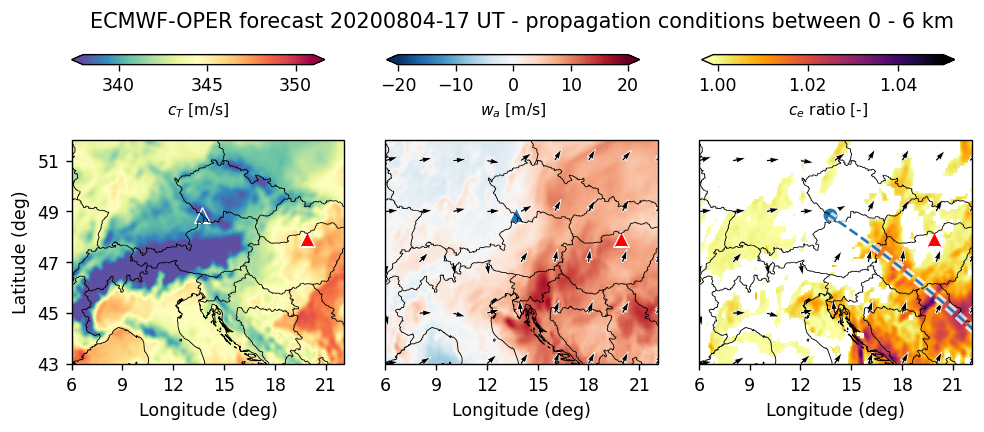

In [25]:
layers = dict()
layers['surface'] = dict(fid='surface', description='Near surface (0-6 km)',
                         selection=dict(level_type='hybrid', lev1=94, lev2=136))

for item in layers.keys():
    plot_infrasound_map_arome(my_atmos, ds, layers[item])

In [26]:
# dspt=ds.interp(longitude=path_params['end']['lon'],
#                latitude=path_params['end']['lat'])

In [27]:
# dspt

In [28]:
# write_profile(dspt, fid_profile)